In [1]:
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/')


In [2]:
# vehicle assignment function
def veh_type_simulator(n_truck, vehicle_type_fraction): # Simulate mode choice
    choice = np.random.multinomial(n_truck, vehicle_type_fraction, size = 1)
    choice = pd.Series(choice[0])
#     print(choice)
    return(choice)

def split_dataframe(df, chunk_size = 100000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [3]:
scenario_name = 'TDA_low'
analysis_year = '2018'
output_dir = 'outputs_aus_2050'
firms = read_csv(output_dir + '/' + analysis_year + '/forecast_firms_with_fleet_' + scenario_name + '.csv')
private_fleet = read_csv('inputs/fleet/TX_private_fleet_size_distribution_V2.csv')
for_hire_fleet = read_csv('inputs/fleet/TX_for_hire_fleet_size_distribution_V2.csv')
for_lease_fleet = read_csv('inputs/fleet/TX_for_lease_fleet_size_distribution_V2.csv')
cargo_type_distribution = read_csv("inputs/fleet/probability_of_cargo_group.csv")

# forecast values
national_fleet_composition = read_csv('inputs/fleet/' + scenario_name + '/TDA_vehicle_stock.csv')
vehicle_type_by_state = read_csv('inputs/fleet/' + scenario_name + '/fleet_composition_by_state.csv')
ev_fraction = read_csv('inputs/fleet/' + scenario_name + '/EV_fraction_by_type.csv')
ev_availability = read_csv('inputs/fleet/' + scenario_name + '/EV_availability.csv')

state_fips_lookup = read_csv('inputs/us-state-ansi-fips.csv')
# vehicle_type_fraction = [0.206287,	0.505178, 0.244464, 0.044071]  # will be replaced once input from Alicia is ready

In [4]:
# filter vehicle composition data

vehicle_type_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Year'] == int(analysis_year)]

national_fleet_composition = \
national_fleet_composition.loc[national_fleet_composition['Year'] == int(analysis_year)]

ev_fraction = ev_fraction.loc[ev_fraction['Year'] == int(analysis_year)]

ev_availability = ev_availability.loc[ev_availability['Year'] == analysis_year]

vehicle_type_by_state.head(5)

,Year,state,Service type,vehicle type,fuel type,vehicle category,veh_fraction
0,2018,ALABAMA,FOR HIRE,Class 4-6 Vocational,Diesel,Diesel Class 4-6 Vocational,0.055964
1,2018,ALABAMA,FOR HIRE,Class 4-6 Vocational,Electric,Electric Class 4-6 Vocational,0.000003
2,2018,ALABAMA,FOR HIRE,Class 4-6 Vocational,Gasoline,Gasoline Class 4-6 Vocational,0.039090
99,2018,ALABAMA,FOR HIRE,Class 7&8 Tractor,Diesel,Diesel Class 7&8 Tractor,0.807661
100,2018,ALABAMA,FOR HIRE,Class 7&8 Tractor,Electric,Electric Class 7&8 Tractor,0.000002


In [5]:
# load b2b output
combined_b2b_flow = None
for i in range(5):
    sctg = i + 1
    sctg_code = 'sctg' + str(sctg)
    file_dir = output_dir + '/' + sctg_code + '_truck/'
    filelist = [file for file in os.listdir(file_dir) if (file.endswith('.csv'))]
    print(sctg_code)
    combined_csv = pd.concat([read_csv(file_dir + f, low_memory=False) for f in filelist ])
    combined_csv = combined_csv.loc[combined_csv['mode_choice'] == 'Private Truck']
    combined_b2b_flow = pd.concat([combined_b2b_flow, combined_csv])
#     break
combined_b2b_flow.head(5)

sctg1
sctg2
sctg3
sctg4
sctg5


,BuyerID,BuyerZone,BuyerNAICS,SellerID,SellerZone,SellerNAICS,TruckLoad,SCTG_Group,shipment_id,orig_FAFID,dest_FAFID,mode_choice,probability,Distance,Travel_time
3,221671,1373,230301,122722,419,212310.0,35.536133,1,11000004,488,488,Private Truck,0.408466,0.0,4.0
6,221671,1373,230301,122722,419,212310.0,35.536133,1,11000007,488,488,Private Truck,0.408466,0.0,4.0
8,221671,1373,230301,122722,419,212310.0,35.536133,1,11000009,488,488,Private Truck,0.408466,0.0,4.0
9,221671,1373,230301,122722,419,212310.0,35.536133,1,11000010,488,488,Private Truck,0.408466,0.0,4.0
10,221671,1373,230301,122722,419,212310.0,35.536133,1,11000011,488,488,Private Truck,0.408466,0.0,4.0


<AxesSubplot:>

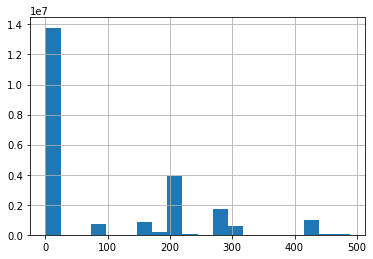

In [6]:
combined_b2b_flow.Distance.hist(bins = 20)

In [7]:
# select firms with private truck shipment
selected_firms_with_load = combined_b2b_flow.groupby(['SellerID'])[['TruckLoad']].sum()
selected_firms_with_load = selected_firms_with_load.reset_index()
selected_firms_with_load.columns = ['BusID', 'Production']
print(len(selected_firms_with_load))
selected_firms_with_load.head(5)

8984


,BusID,Production
0,1017,65508.461183
1,1078,39084.717711
2,1158,225.352214
3,2397,2713.077151
4,2408,17985.471890


In [8]:
# separate firms with/without private truck shipment
print(len(firms))
selected_sellers = selected_firms_with_load.BusID.unique()
firms_without_adj = firms.loc[~firms['BusID'].isin(selected_sellers)]
firms_with_adj = pd.merge(firms, selected_firms_with_load,
                          on = 'BusID', how = 'inner')
print(len(firms_without_adj))
print(len(firms_with_adj))
firms_with_adj.head(5)

8285155
8276171
8984


,Unnamed: 0,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,EV_powertrain (if any),Production
0,25,48375,489,1,31161A,5,0.002975,862487,4793,35.209945,...,TEXAS,0,0,0,0,0,0,0,Battery Electric,7.840500
1,757,48241,489,1,322120,27,0.013845,919375,3683,30.801538,...,TEXAS,0,0,0,0,0,0,0,Battery Electric,59954.318762
2,908,94,409,1,311615,5,0.015306,865140,20094,34.231424,...,OKLAHOMA,0,0,0,0,0,0,0,Battery Electric,4303.226864
3,909,94,409,1,311615,5,0.015306,865141,20094,34.789015,...,OKLAHOMA,0,0,0,0,0,0,0,Battery Electric,254.365917
4,1306,48309,489,1,325412,23,0.019942,957178,4204,31.560594,...,TEXAS,0,0,0,0,0,0,0,Battery Electric,72690.294220


In [9]:
# format fleet composition
list_of_veh_tech = vehicle_type_by_state['vehicle category'].unique().tolist()

private_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'PRIVATE']
private_fleet_by_state_wide = pd.pivot_table(private_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
private_fleet_by_state_wide = private_fleet_by_state_wide.reset_index()


for_hire_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'FOR HIRE']
for_hire_fleet_by_state_wide = pd.pivot_table(for_hire_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_hire_fleet_by_state_wide = for_hire_fleet_by_state_wide.reset_index()


for_lease_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'LEASE']
for_lease_fleet_by_state_wide = pd.pivot_table(for_lease_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_lease_fleet_by_state_wide = for_lease_fleet_by_state_wide.reset_index()

private_fleet_by_state_wide.head(5)

vehicle category,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,ALABAMA,0.243046,0.303801,0.282828,0.000012,6.467405e-07,2.889022e-07,0.169764
1,ALASKA,0.275343,0.221711,0.309854,0.000014,4.719849e-07,3.165081e-07,0.192323
2,ARIZONA,0.274482,0.308356,0.224665,0.000013,6.564382e-07,2.294897e-07,0.191722
3,ARKANSAS,0.158329,0.538997,0.191483,0.000008,1.147434e-06,1.955959e-07,0.110591
4,CALIFORNIA,0.279156,0.327610,0.197732,0.000014,6.974263e-07,2.019784e-07,0.194987


In [10]:
print(firms_with_adj.columns)
firms_with_adj = firms_with_adj[['Unnamed: 0', 'esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'Production']]

Index(['Unnamed: 0', 'CBPZONE', 'FAFZONE', 'esizecat', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'n_trucks',
       'st', 'stname', 'stusps', 'state', 'Diesel Class 4-6 Vocational',
       'Diesel Class 7&8 Tractor', 'Diesel Class 7&8 Vocational',
       'Electric Class 4-6 Vocational', 'Electric Class 7&8 Tractor',
       'Electric Class 7&8 Vocational', 'Gasoline Class 4-6 Vocational',
       'EV_powertrain (if any)', 'Production'],
      dtype='object')


8984


,fleet_size,min_size,fraction_of_carrier,avg_truck_per_carrier,total_truck_std,n_trucks
2,6-10,6,0.069209,7.476603,1.370730,9
0,0-2,0,0.709745,1.218434,0.413643,2
0,0-2,0,0.709745,1.218434,0.413643,1
0,0-2,0,0.709745,1.218434,0.413643,1
1,3-5,3,0.154389,3.692529,0.778908,4


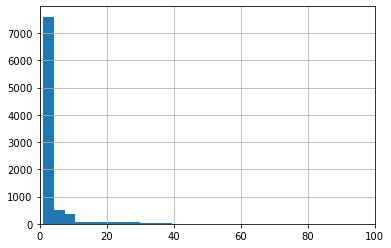

In [11]:
# re-generate fleet size for selected firms
sample_size = len(firms_with_adj)
# print(tx_private_fleet.columns)
private_fleet_short = private_fleet[['fleet_size', 'min_size', 
                                    'fraction_of_carrier', 
                                    'avg_truck_per_carrier', 
                                    'total_truck_std']]

firm_fleet_sample = \
private_fleet_short.sample(n = sample_size,
                           weights = private_fleet_short['fraction_of_carrier'],
                           replace = True)
print(len(firm_fleet_sample))
# generate random fleet size
firm_fleet_sample.loc[:, 'n_trucks'] = np.random.normal(loc = firm_fleet_sample.loc[:, 'avg_truck_per_carrier'],
                                                   scale = firm_fleet_sample.loc[:, 'total_truck_std'])
criteria = (firm_fleet_sample['n_trucks'] <= 1)
firm_fleet_sample.loc[criteria, 'n_trucks'] = 1
firm_fleet_sample.loc[:, 'n_trucks'] = np.round(firm_fleet_sample.loc[:, 'n_trucks'], 0)
firm_fleet_sample.loc[:, 'n_trucks'] = firm_fleet_sample.loc[:, 'n_trucks'].astype(int)

firm_fleet_sample['n_trucks'].hist(bins = 1000)
plt.xlim([0,100])
firm_fleet_sample.head(5)

In [12]:
# append vehicle composition to firms by state
firm_fleet_sample = firm_fleet_sample.sort_values(by = ['n_trucks'], ascending = True)
firms_with_adj = firms_with_adj.sort_values(by = ['Production'], ascending = True)

firm_fleet_sample_short = firm_fleet_sample[['n_trucks']]

firms_with_fleet = pd.concat([firms_with_adj.reset_index(drop=True), 
                              firm_fleet_sample_short.reset_index(drop=True)], axis=1)

firms_with_fleet.loc[:, 'FAFZONE'] = firms_with_fleet.loc[:,'FAFZONE'].astype(str).str.zfill(3)
firms_with_fleet.loc[:, 'st'] = firms_with_fleet.loc[:, 'FAFZONE'].str[:2]
firms_with_fleet.loc[:, 'st'] = firms_with_fleet.loc[:, 'st'].astype(int)

firms_with_fleet = pd.merge(firms_with_fleet, state_fips_lookup,
                            on = 'st', how = 'left')

firms_with_fleet.loc[:,'stname'] = firms_with_fleet.loc[:,'stname'].str.upper()

firms_with_fleet = pd.merge(firms_with_fleet, private_fleet_by_state_wide,
                            left_on = 'stname', right_on = 'state', how = 'left')

firms_with_fleet.head(5)

,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,76127,1,48165,489,424700,18,0.5,1478882,2736,32.935055,...,TEXAS,TX,TEXAS,0.191381,0.482841,0.191899,0.000009,0.000001,1.960198e-07,0.133677
1,76182,1,48347,489,424700,17,0.5,1474574,4632,31.590505,...,TEXAS,TX,TEXAS,0.191381,0.482841,0.191899,0.000009,0.000001,1.960198e-07,0.133677
2,76141,1,48265,489,424700,18,0.5,1469942,3771,30.070353,...,TEXAS,TX,TEXAS,0.191381,0.482841,0.191899,0.000009,0.000001,1.960198e-07,0.133677
3,76480,1,48299,489,424700,18,0.5,1478392,3950,30.567864,...,TEXAS,TX,TEXAS,0.191381,0.482841,0.191899,0.000009,0.000001,1.960198e-07,0.133677
4,2722686,1,48163,489,424700,17,3.5,1471305,2729,28.767135,...,TEXAS,TX,TEXAS,0.191381,0.482841,0.191899,0.000009,0.000001,1.960198e-07,0.133677


In [13]:
# assign vehicle technology
chunks = split_dataframe(firms_with_fleet)
i = 0
for chunk in chunks:
    print('processing chunk ' + str(i))
    chunk[list_of_veh_tech] = \
    chunk.apply(
            lambda row: veh_type_simulator(row['n_trucks'], row[list_of_veh_tech]), axis=1, result_type ='expand')
    # print(np.random.multinomial(testing_fleet_sample['n_trucks'], vehicle_type_fraction))
    if i==0:
        firms_with_fleet = chunk
    else:
        firms_with_fleet = pd.concat([firms_with_fleet, chunk])
    i += 1
firms_with_fleet.head(5)

processing chunk 0


,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,76127,1,48165,489,424700,18,0.5,1478882,2736,32.935055,...,TEXAS,TX,TEXAS,0,0,0,0,0,0,1
1,76182,1,48347,489,424700,17,0.5,1474574,4632,31.590505,...,TEXAS,TX,TEXAS,0,0,0,0,0,0,1
2,76141,1,48265,489,424700,18,0.5,1469942,3771,30.070353,...,TEXAS,TX,TEXAS,0,1,0,0,0,0,0
3,76480,1,48299,489,424700,18,0.5,1478392,3950,30.567864,...,TEXAS,TX,TEXAS,0,1,0,0,0,0,0
4,2722686,1,48163,489,424700,17,3.5,1471305,2729,28.767135,...,TEXAS,TX,TEXAS,0,1,0,0,0,0,0


In [14]:
# assign EV type
# print(ev_fraction)

# carriers_with_fleet.loc[:, 'n_trucks'] = carriers_with_fleet.loc[:, list_of_veh_tech].sum(axis = 1)
# leasing_with_fleet.loc[:, 'n_trucks'] = leasing_with_fleet.loc[:, list_of_veh_tech].sum(axis = 1)

powertrain = ev_fraction.Powertrain.to_numpy()
print(powertrain)
probability = ev_fraction.EV_fraction.to_numpy()

sample_size = len(firms_with_fleet)
firms_with_fleet.loc[:, 'EV_powertrain (if any)'] = \
pd.Series(np.random.choice(powertrain, size = sample_size, p=probability) ) 

firms_with_fleet.head(5)

['Battery Electric' 'H2 Fuel Cell' 'PHEV Diesel' 'PHEV Gasoline']


,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,EV_powertrain (if any)
0,76127,1,48165,489,424700,18,0.5,1478882,2736,32.935055,...,TX,TEXAS,0,0,0,0,0,0,1,Battery Electric
1,76182,1,48347,489,424700,17,0.5,1474574,4632,31.590505,...,TX,TEXAS,0,0,0,0,0,0,1,Battery Electric
2,76141,1,48265,489,424700,18,0.5,1469942,3771,30.070353,...,TX,TEXAS,0,1,0,0,0,0,0,Battery Electric
3,76480,1,48299,489,424700,18,0.5,1478392,3950,30.567864,...,TX,TEXAS,0,1,0,0,0,0,0,Battery Electric
4,2722686,1,48163,489,424700,17,3.5,1471305,2729,28.767135,...,TX,TEXAS,0,1,0,0,0,0,0,Battery Electric


In [15]:
firms_with_fleet.loc[firms_with_fleet['EV_powertrain (if any)'].isin(['PHEV Diesel', 'PHEV Gasoline']), 'EV_powertrain (if any)'] = 'PHEV'

In [16]:
firms_with_fleet = firms_with_fleet.drop(columns=['Unnamed: 0', 'Production'])
firms_without_adj = firms_without_adj.drop(columns=['Unnamed: 0'])
firms_output = pd.concat([firms_without_adj, firms_with_fleet])
print(len(firms_output))
firms_output.head(5)

8285155


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,EV_powertrain (if any)
0,56,251,1,52A000,0,0.000635,3151496,20056,42.843757,-70.758827,...,MA,MASSACHUSETTS,0,0,0,0,0,0,0,Battery Electric
1,29,132,1,336411,37,0.001221,1099966,20029,32.263037,-81.669580,...,GA,GEORGIA,0,0,0,0,0,0,0,Battery Electric
2,41,190,1,335222,34,0.001437,1088473,20041,42.467350,-92.444601,...,IA,IOWA,0,0,0,0,0,0,0,Battery Electric
3,22,111,1,522A00,0,0.001840,3184607,20022,38.932896,-76.964109,...,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0,Battery Electric
4,22,111,1,522A00,0,0.001840,3184608,20022,38.922030,-76.960551,...,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0,Battery Electric


In [17]:
# writing output
firms_output.to_csv(output_dir + '/' + analysis_year + '/synthetic_firms_with_fleet_'+ scenario_name + '_mc_adjusted.csv')